# Training and Evaluating Models with the Data-Driven Library

This notebook provides an overview of the tools built in the DDM for extracting predictions from your trained DDM and for evauating the performance of the DDM.

---

We utilize `hydra` to save the configuration of our datasets and our models. The default configuration is in the `conf/config.yaml` directory:

```YAML
defaults:
  - data: house_energy.yaml
  - model: xgboost.yaml
  - simulator: house_energy_simulator.yaml
```

Note that the configuration file points to three additional configuration files for each component: the data, the model, and the simulator.

While the configuration file already has default values specified you can override any element of the configuration file using the `overrides` option. For example, we can override the data configuration to instead use the `yaml` file specified in `data/cartpole-100K-cts.csv.yaml` and the model configuration to use the `yaml` file specified in `model/SVR.yaml`.


In [1]:
cd ..

/home/alizaidi/bonsai/datadrivenmodel


In [2]:
from hydra.experimental import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from model_loader import available_models
import logging
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.logging import RichHandler
import copy
from assessment_metrics_loader import available_metrics

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler()]
)
logger = logging.getLogger("ddm_notebook")
logger.setLevel(logging.INFO)

In [3]:
GlobalHydra.instance().clear() 
initialize(config_path="../conf", job_name="model_train_validate")
# cfg = compose(config_name="config", overrides=["data=house_energy", "model=xgboost", "simulator=house_energy_simparam"])
# cfg = compose(config_name="config", overrides=["data=cartpole_st1_at", "model=xgboost", "simulator=cartpole_simparam"])
# cfg = compose(config_name="config", overrides=["data=cartpole_st1_at", "model=xgboost", "simulator=cartpole_simparam", "data.concatenated_steps=0", "data.concatenate_length=None"])
cfg = compose(config_name="config", overrides=["data=cartpole_mixed", "model=xgboost", "simulator=cartpole_mixed_simparam"])
# cfg = compose(config_name="config", overrides=["data=moab_5Kepi", "model=xgboost", "simulator=moab_simparam_wconfig"])

/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/cartpole_mixed.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/xgboost.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive simulator/cartpole_mixed_simparam.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWa

In [4]:
WANDB_LOGGER=True

In [5]:
%env "WANDB_NOTEBOOK_NAME" "ddm_train_evaluate.ipynb"
if WANDB_LOGGER:
    import datetime
    import wandb
    wandb.login()
    wandb.init(
        project="ddm-train-eval-runs", group="cartpole", name="cartpole-mixed-with-var-concat-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"), config=cfg)

env: "WANDB_NOTEBOOK_NAME"="ddm_train_evaluate.ipynb"


[18:25:51] ERROR    Failed to detect the name of this notebook, you can set it manually with the     ]8;id=250210;file:///anaconda/envs/ddm/lib/python3.7/site-packages/wandb/jupyter.py\jupyter.py]8;;\:]8;id=620449;file:///anaconda/envs/ddm/lib/python3.7/site-packages/wandb/jupyter.py#237\237]8;;\
                    WANDB_NOTEBOOK_NAME environment variable to enable code saving.                                

wandb: Currently logged in as: alizaidi. Use `wandb login --relogin` to force relogin


In [6]:
cfg

{'data': {'path': 'csv_data/cartpole_mixed_100k.csv', 'full_or_relative': 'relative', 'inputs': ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity'], 'outputs': ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity'], 'augmented_cols': ['pole_length', 'pole_mass', 'cart_mass', 'command'], 'iteration_order': -1, 'episode_col': 'episode', 'iteration_col': 'iteration', 'max_rows': -1, 'test_perc': 0.25, 'scale_data': True, 'diff_state': False, 'concatenated_steps': 5, 'concatenated_zero_padding': True, 'concatenate_length': {'cart_position': 2, 'cart_velocity': 2, 'pole_angle': 3, 'pole_angular_velocity': 10, 'command': 4}}, 'model': {'name': 'xgboost', 'build_params': {'model_type': 'xgboost', 'fit_separate': False, 'halt_model': False, 'n_estimators': 100, 'objective': 'reg:squarederror', 'learning_rate': 0.3, 'scale_data': True, 'max_depth': 6}, 'saver': {'filename': 'models/xgboost_models/house_energy'}, 'sweep': {'run': False, 'split_strategy': 

## 1. Importing the Dataset

In [7]:
# Extract features from yaml file
from numpy import concatenate


input_cols = cfg['data']['inputs']
output_cols = cfg['data']['outputs']
augmented_cols = cfg['data']['augmented_cols']
dataset_path = cfg['data']['path']
iteration_order = cfg['data']['iteration_order']
episode_col = cfg['data']['episode_col']
iteration_col = cfg['data']['iteration_col']
# max_rows = cfg['data']['max_rows']
max_rows = 50_000
diff_state = cfg['data']['diff_state']
test_perc = cfg['data']['test_perc']
concatenated_steps = cfg["data"]["concatenated_steps"]
concatenated_zero_padding = cfg["data"]["concatenated_zero_padding"]
concatenate_length = cfg["data"]["concatenate_length"]

In [8]:
print("DATA STRUCTURE SELECTED:")
print(" - input_cols:", input_cols)
print(" - augmented_cols:", augmented_cols)
print(" - output_cols:", output_cols)

DATA STRUCTURE SELECTED:

- input_cols: ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

- augmented_cols: ['pole_length', 'pole_mass', 'cart_mass', 'command']

- output_cols: ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

##  2. Model Definition

The `available_models` dictionary provides wrappers for the available models in this repository. We utilize `cfg["model"]` to load and build the model specified in the `model.yaml` file.

### Hyperparameters

Every model has its own hyperparameters, specified through the `cfg["model"]["build_params"]` dictionary, which can be modified directly in the dictionary below or through the `hydra` overrides.

In [9]:
cfg["model"]["build_params"]

{'model_type': 'xgboost', 'fit_separate': False, 'halt_model': False, 'n_estimators': 100, 'objective': 'reg:squarederror', 'learning_rate': 0.3, 'scale_data': True, 'max_depth': 6}

## 3. Train the Model

In [10]:
def train_models(config=cfg):

    logger.info(f'Model type: {available_models[config["model"]["name"]]}')
    Model = available_models[config["model"]["name"]]
    model = Model()
    logger.info(f"Building model with parameters: {config}")
    model.build_model(
        **config["model"]["build_params"]
    )
    logger.info(f"Loading data from {dataset_path}")
    global X_train, y_train, episode_ids_train, X_test, y_test
    X_train, y_train, X_test, y_test = model.load_csv(
        input_cols=input_cols,
        output_cols=output_cols,
        augm_cols=list(augmented_cols),
        dataset_path=dataset_path,
        iteration_order=iteration_order,
        episode_col=episode_col,
        iteration_col=iteration_col,
        max_rows=max_rows,
        diff_state=diff_state,
        test_perc=test_perc,
        concatenated_steps=concatenated_steps,
        concatenated_zero_padding=concatenated_zero_padding,
        concatenate_var_length=concatenate_length
    )
    
    logger.info(f"Fitting model...")
    model.fit(X_train, y_train)
    logger.info(f"Model trained!")
    y_pred = model.predict(X_test)
    r2_score = available_metrics["r2_score"]
    logger.info(f"R^2 score is {r2_score(y_test,y_pred)} for the test set.")

    return model

In [11]:
model = train_models(cfg)

[18:25:53] INFO     Model type: <class 'gboost_models.GBoostModel'>               ]8;id=629165;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=459613;file://<ipython-input-10-947f7e075198>#3\3]8;;\

           INFO     Building model with parameters: {'data': {'path':             ]8;id=350311;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=602118;file://<ipython-input-10-947f7e075198>#6\6]8;;\
                    'csv_data/cartpole_mixed_100k.csv', 'full_or_relative':                                        
                    'relative', 'inputs': ['cart_position', 'cart_velocity',                                       
                    'pole_angle', 'pole_angular_velocity'], 'outputs':                                             
                    ['cart_position', 'cart_velocity', 'pole_angle',                                               
                    'pole_angular_velocity'], 'augmented_cols': ['pole_length',                                    
                    'pole_mass', 'cart_mass', 'command'], 'iteration_order': -1,                                   
                    'episode_col': 'episode', 'iteration_col': 'iteration',                                        
                    'max_rows': -1, 'test_perc': 0.25, 'scale_data': True,                                         
                    'diff_state': False, 'concatenated_steps': 5,                                                  
                    'concatenated_zero_padding': True, 'concatenate_length':                                       
                    {'cart_position': 2, 'cart_velocity': 2, 'pole_angle': 3,                                      
                    'pole_angular_velocity': 10, 'command': 4}}, 'model':                                          
                    {'name': 'xgboost', 'build_params': {'model_type': 'xgboost',                                  
                    'fit_separate': False, 'halt_model': False, 'n_estimators':                                    
                    100, 'objective': 'reg:squarederror', 'learning_rate': 0.3,                                    
                    'scale_data': True, 'max_depth': 6}, 'saver': {'filename':                                     
                    'models/xgboost_models/house_energy'}, 'sweep': {'run':                                        
                    False, 'split_strategy': 'timeseries', 'search_algorithm':                                     
                    'bayesian', 'num_trials': 15, 'scoring_func': 'r2',                                            
                    'early_stopping': False, 'results_csv_path':                                                   
                    'xgboost_gridsearch/search_results.csv', 'params':                                             
                    {'estimator__max_depth': [1, 3, 5, 10], 'estimator__gamma':                                    
                    [0, 0.5, 1, 5], 'estimator__subsample': [0.1, 0.5, 1],                                         
                    'estimator__eta': [0.3, 0.1, 0.5]}}}, 'simulator': {'states':                                  
                    ['cart_position', 'cart_velocity', 'pole_angle',                                               
                    'pole_angular_velocity'], 'actions': ['command'], 'configs':                                   
                    ['pole_length', 'pole_mass', 'cart_mass'], 'episode_inits':                                    
                    {'pole_length': 0.4, 'pole_mass': 0.055, 'cart_mass': 0.31},                                   
                    'initial_states': {'cart_position': {'inkling_name':                                           
                    'initial_cart_position', 'min': -0.05, 'max': 0.05},                                           
                    'cart_velocity': {'inkling_name': 'initial_cart_velocity',                                     
                    'min': -0.05, 'max': 0.05}, 'pole_angle': {'inkling_name':                                     
                    'initial_pole_angle', 'min':

           INFO     Loading data from csv_data/cartpole_mixed_100k.csv           ]8;id=707492;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=93967;file://<ipython-input-10-947f7e075198>#10\10]8;;\

           INFO     Using ['cart_position', 'cart_velocity', 'pole_angle',                         ]8;id=93122;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=416479;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#322\322]8;;\
                    'pole_angular_velocity', 'pole_length', 'pole_mass', 'cart_mass', 'command']                   
                    as the features for modeling DDM                                                               

           INFO     Using ['cart_position', 'cart_velocity', 'pole_angle',                         ]8;id=3253;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=426416;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#333\333]8;;\
                    'pole_angular_velocity'] as the labels for modeling DDM                                        

           INFO     Iteration order set to -1 so using inputs from previous -1 row                  ]8;id=175098;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=44123;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#86\86]8;;\

/anaconda/envs/ddm/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


           INFO     Feature columns are: ['prev_cart_position', 'prev_cart_velocity',              ]8;id=530150;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=208090;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#128\128]8;;\
                    'prev_pole_angle', 'prev_pole_angular_velocity', 'pole_length', 'pole_mass',                   
                    'cart_mass', 'command']                                                                        

[18:25:54] INFO     Label columns are: ['cart_position', 'cart_velocity', 'pole_angle',            ]8;id=447498;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=315497;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#129\129]8;;\
                    'pole_angular_velocity']                                                                       

           INFO     Trimmed DataFrame across episodes. found (294) episodes.                       ]8;id=953;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=957586;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#416\416]8;;\

           INFO     Using previous 5 lags for all features as inputs and using padding: True       ]8;id=171488;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=586072;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#371\371]8;;\

           INFO     Features after incorporating lagged features: ['pole_length', 'pole_mass',     ]8;id=287637;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=139585;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#859\859]8;;\
                    'cart_mass', 'command_1', 'command_2', 'command_3', 'command_4',                               
                    'prev_cart_position_1', 'prev_cart_position_2', 'prev_cart_velocity_1',                        
                    'prev_cart_velocity_2', 'prev_pole_angle_1', 'prev_pole_angle_2',                              
                    'prev_pole_angle_3', 'prev_pole_angular_velocity_1',                                           
                    'prev_pole_angular_velocity_2', 'prev_pole_angular_velocity_3',                                
                    'prev_pole_angular_velocity_4', 'prev_pole_angular_velocity_5',                                
                    'prev_pole_angular_velocity_6', 'prev_pole_angular_velocity_7',                                
                    'prev_pole_angular_velocity_8', 'prev_pole_angular_velocity_9',                                
                    'prev_pole_angular_velocity_10']                                                               

[18:25:56] INFO     Divided train & test set with (37263) and (12443) iterations, respectively.    ]8;id=885992;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=222687;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#462\462]8;;\
                    Chosen split == 75.0%.                                                                         
                       >> Average episode length: (169.06802721088437). Average std dev:                           
                    (93.5469368066321)                                                                             

           INFO     Features: ['pole_length', 'pole_mass', 'cart_mass', 'command_1', 'command_2',  ]8;id=467602;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=511892;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#544\544]8;;\
                    'command_3', 'command_4', 'prev_cart_position_1', 'prev_cart_position_2',                      
                    'prev_cart_velocity_1', 'prev_cart_velocity_2', 'prev_pole_angle_1',                           
                    'prev_pole_angle_2', 'prev_pole_angle_3', 'prev_pole_angular_velocity_1',                      
                    'prev_pole_angular_velocity_2', 'prev_pole_angular_velocity_3',                                
                    'prev_pole_angular_velocity_4', 'prev_pole_angular_velocity_5',                                
                    'prev_pole_angular_velocity_6', 'prev_pole_angular_velocity_7',                                
                    'prev_pole_angular_velocity_8', 'prev_pole_angular_velocity_9',                                
                    'prev_pole_angular_velocity_10']                                                               

           INFO     Fitting model...                                             ]8;id=43583;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=567585;file://<ipython-input-10-947f7e075198>#28\28]8;;\

/anaconda/envs/ddm/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[18:26:08] INFO     Model trained!                                               ]8;id=115658;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=400913;file://<ipython-input-10-947f7e075198>#30\30]8;;\

           INFO     R^2 score is 0.9957137937585014 for the test set.            ]8;id=431474;file://<ipython-input-10-947f7e075198>\<ipython-input-10-947f7e075198>]8;;\:]8;id=398164;file://<ipython-input-10-947f7e075198>#33\33]8;;\

### Save Model

In [12]:
model.save_model(filename=cfg["model"]["saver"]["filename"])

           INFO     Scale transformations used, saving to                                      ]8;id=380673;file:///home/alizaidi/bonsai/datadrivenmodel/gboost_models.py\gboost_models.py]8;;\:]8;id=180493;file:///home/alizaidi/bonsai/datadrivenmodel/gboost_models.py#136\136]8;;\
                    models/xgboost_models/house_energy.pkl                                                         

### Data Structure of Saved model

In [13]:
logger.info(f"Input_cols:  {model.features}")
logger.info(f"Output_cols: {model.labels}")

           INFO     Input_cols:  ['cart_position', 'cart_velocity', 'pole_angle', ]8;id=48060;file://<ipython-input-13-3da48a5edf65>\<ipython-input-13-3da48a5edf65>]8;;\:]8;id=110760;file://<ipython-input-13-3da48a5edf65>#1\1]8;;\
                    'pole_angular_velocity', 'pole_length', 'pole_mass',                                           
                    'cart_mass', 'command']                                                                        

           INFO     Output_cols: ['cart_position', 'cart_velocity', 'pole_angle', ]8;id=441884;file://<ipython-input-13-3da48a5edf65>\<ipython-input-13-3da48a5edf65>]8;;\:]8;id=709320;file://<ipython-input-13-3da48a5edf65>#2\2]8;;\
                    'pole_angular_velocity']                                                                       

## 4. Model Evaluations

We provide three methods for evaluating the errors of our trained models:

1. Model predictive error: using a specified metric (such as R^2 or RMSE) and a test set, we evaluate the metric on the test set.
2. Visualization of per-iteration predictions on a test set.
3. Visualization of sequential predictions on a test set. Sequential prediction refers to feeding the predicted output back into the input over a full episode.

### 4.1. Per-Iteration Predictions

In [14]:
# Use the the input columns at time t to predict the output column(s) at time t+1
y_preds = model.predict(X_test)

In [15]:
# Plot all prediction results
label_count = np.shape(y_preds)[1]
for i in range(label_count):
    fig = plt.figure(figsize=(20,5))
    plt.plot(y_test[:,i], "green")
    plt.plot(y_preds[:,i], "brown")
    plt.title(f"Per-iteration predictions: {model.labels[i]}")
    plt.xlabel("Iteration")
    plt.legend(["Truth", "Prediction"])
    if WANDB_LOGGER:
        wandb.log({f"Per-iteration predictions: {model.labels[i]}": plt})


/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



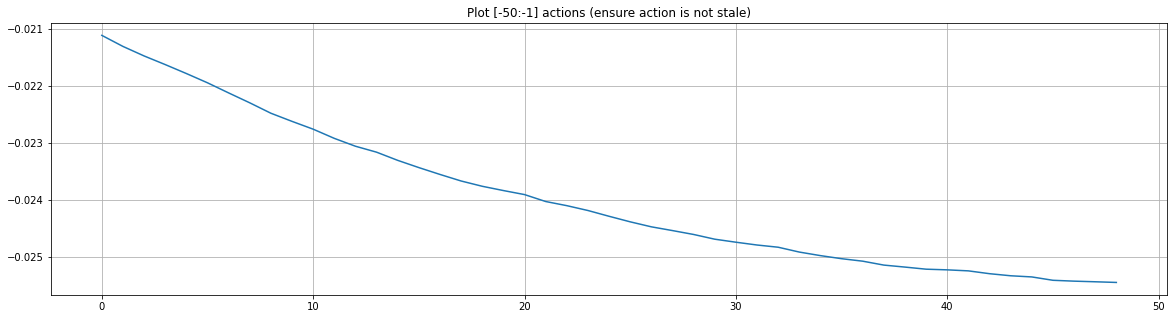

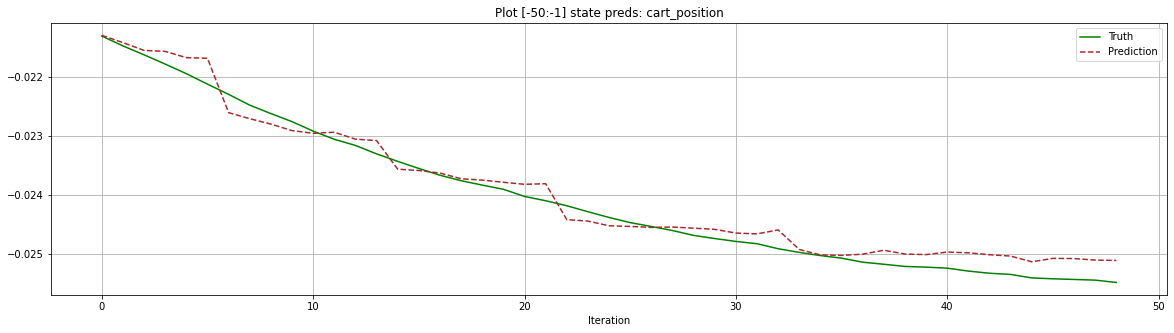

In [16]:
# Zoom in on a specific section
iteration_start = -50
iteration_stop = -1

# Define which input column is the action
action_col = cfg["simulator"]["actions"][0]

# Plot action changes -- zoomed in
fig = plt.figure(figsize=(20,5))
action_idx = model.features.index(action_col)
plt.title(f"Plot [{iteration_start}:{iteration_stop}] actions (ensure action is not stale)")
plt.plot(X_test[iteration_start:iteration_stop,action_idx])
plt.grid()
    
# Plot state (model output) changes -- zoomed in
fig = plt.figure(figsize=(20,5))
label_idx = 0
plt.title(f"Plot [{iteration_start}:{iteration_stop}] state preds: {model.labels[label_idx]}")
plt.plot(y_test[iteration_start:iteration_stop,label_idx], "green")
plt.plot(y_preds[iteration_start:iteration_stop,label_idx], "brown", linestyle='--')
plt.xlabel("Iteration")
plt.legend(["Truth", "Prediction"])
plt.grid()

### 4.2. Overall Prediction Score

In [17]:
# Select your scoring method: r2_score, root_mean_squared_error, or mean_squared_error
scoring_method = available_metrics["r2_score"]

In [18]:
# Evaluate the model using the test set
per_iteration_eval_table = model.evaluate(scoring_method, y_preds, y_test, marginal=True)

In [19]:
if (per_iteration_eval_table["score"] < 0.7).any():
    logger.warn("Per-iteration assessment R^2 is low. Please review your model.")

per_iteration_eval_table

,var,score
0,cart_position,0.994631
1,cart_velocity,0.995381
2,pole_angle,0.996522
3,pole_angular_velocity,0.996321


### 4.3. Sequential Predictions

In [20]:
# in order to run sequential predictions we need to segment
# the data by episodes so we can do multi-step predictions within each
# episode
X_test_grouped, y_test_grouped = model.get_test_set(grouped_per_episode=True)

In [21]:
# Feed the predicted output back into the input for full episodes.
preds_sequentially_grouped, labels_sequentially_grouped = model.predict_sequentially(X_test_grouped, y_test_grouped, return_flattened=False)

/anaconda/envs/ddm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



X (predict_sequentially) ---> (72,)


In [22]:
# Plot sequential predictions for first test episode. 
# Do you notice any error propagation (i.e., predictions deviate more from truth over time)?
label_count = np.shape(preds_sequentially_grouped[0])[1]
for i in range(label_count):
    fig = plt.figure(figsize=(20,5))
    plt.plot(y_test_grouped[0][:,i], "green")
    plt.plot(preds_sequentially_grouped[0][:,i], "brown")
    plt.title(f"Sequential predictions: {model.labels[i]}")
    plt.xlabel("Iteration")
    plt.legend(["Truth", "Prediction"])
    if WANDB_LOGGER:
        wandb.log({f"Sequential multi-step predictions: {model.labels[i]}": plt})

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/anaconda/envs/ddm/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [23]:
# Evaluate the model sequentially using the test set and output a scoring metric.
sequential_eval_table = model.evaluate(scoring_method, np.concatenate(preds_sequentially_grouped), np.concatenate(y_test_grouped), marginal=True)

In [24]:
if (sequential_eval_table["score"] < 0.7).any():
    logger.warn("Sequential assessment R^2 is low. Please review your model.")

sequential_eval_table

/anaconda/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

The 'warn' method is deprecated, use 'warning' instead



[18:26:46] WARNING  Sequential assessment R^2 is low. Please review your model.   ]8;id=583660;file://<ipython-input-24-4ee6cb7325d7>\<ipython-input-24-4ee6cb7325d7>]8;;\:]8;id=538712;file://<ipython-input-24-4ee6cb7325d7>#2\2]8;;\

,var,score
0,cart_position,-0.018077
1,cart_velocity,-0.149063
2,pole_angle,-2.102725
3,pole_angular_velocity,0.755125


In [25]:
if WANDB_LOGGER:
    wandb.log(sequential_eval_table.set_index("var")["score"].to_dict())

## 5. Comparing Model Evaluations

If you want to compare various models, you can use the following section to save them in between runs.

1. Select appropriate "model_name" tag, and run this section
2. Change config through "config.yaml" (located at 'conf' folder)
3. Rerun from Model Build (Steps 1-4), until this section
4. Define a new value for "model_name" tag, and run this section again

In [26]:
# select model name, and feats to extract
model_name = "svr"

In [27]:
# per-iteration score
model_per_it_scores = copy.deepcopy(per_iteration_eval_table)

In [28]:
# initialize models dictionary if it doesn't exist already
if 'models_dict' not in locals():
    models_dict = dict()

In [29]:
# append tables to model using selected model name as key
models_dict[model_name] = (model_per_it_scores,)

In [30]:
# redefine column names if needed
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        for col_name in score_table.columns:
            if "score" in col_name and model_name not in col_name:
                score_table.rename(columns = {col_name:model_name+"_"+col_name}, inplace = True)

In [31]:
# concatenate across all models
all_scores = None
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        if all_scores is None:
            all_scores = score_table
        else:
            all_scores = all_scores.merge(score_table,how='outer')

all_scores

,var,svr_score
0,cart_position,0.994631
1,cart_velocity,0.995381
2,pole_angle,0.996522
3,pole_angular_velocity,0.996321
